###  Step 1 – Load and Merge Lecture Dataset

This step loads all  `.csv` files from the provided ZIP archive. Each file contains WiFi probe requests generated by a specific device. We merge them into a single `DataFrame`, adding a `Label` column to track the original device.

**Goal**: Prepare a unified, labeled dataset for clustering by combining probe request data from all devices.


In [20]:
# Step 1: Load and Merge Lecture Dataset
import pandas as pd
import os
import zipfile

# Paths
zip_path = "/content/MAC_derand_lecture-dataset.zip"
extract_path = "/content/lecture_dataset"

# Unzip
!unzip -o -q "{zip_path}" -d "{extract_path}"

# Load and combine CSVs
df_list = []
base_dir = os.path.join(extract_path, "lecture-dataset")

for root, _, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".csv") and "__MACOSX" not in file:
            path = os.path.join(root, file)
            df = pd.read_csv(path)
            if "Label" not in df.columns:
                df["Label"] = os.path.splitext(file)[0]
            df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)
combined_df["Timestamp"] = pd.to_datetime(combined_df["Timestamp"], unit="s")

# Filter to probe requests only
combined_df = combined_df[combined_df["SSID"].isna()]

print(f" Loaded {len(combined_df)} probe requests from {combined_df['Label'].nunique()} devices.")
combined_df.head()


 Loaded 4561 probe requests from 7 devices.


,Timestamp,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,SSID,Supported Rates,Extended Supported Rates,VHT Capabilities,HE Capabilities,Length,Label
0,2023-05-20 13:29:58.574080944,76:f7:2b:0e:35:f3,1,1.0,2d001bffff000000000000000000000000000000000000...,4.004880e+18,00904c0408bf0c7678910ffaff0000faff0020,NaN,82848b96,0c1218243048606c,NaN,020014,193,S21Ultra-M_a
1,2023-05-20 13:29:58.574084044,76:f7:2b:0e:35:f3,1,1.0,2d001bffff000000000000000000000000000000000000...,4.004880e+18,00904c0408bf0c7678910ffaff0000faff0020,NaN,82848b96,0c1218243048606c,NaN,020014,193,S21Ultra-M_a
2,2023-05-20 13:29:58.814193010,76:f7:2b:0e:35:f3,6,6.0,2d001bffff000000000000000000000000000000000000...,4.004880e+18,00904c0408bf0c7678910ffaff0000faff0020,NaN,82848b96,0c1218243048606c,NaN,020014,193,S21Ultra-M_a
3,2023-05-20 13:29:58.814196110,76:f7:2b:0e:35:f3,6,6.0,2d001bffff000000000000000000000000000000000000...,4.004880e+18,00904c0408bf0c7678910ffaff0000faff0020,NaN,82848b96,0c1218243048606c,NaN,020014,193,S21Ultra-M_a
4,2023-05-20 13:29:59.015255928,76:f7:2b:0e:35:f3,11,11.0,2d001bffff000000000000000000000000000000000000...,4.004880e+18,00904c0408bf0c7678910ffaff0000faff0020,NaN,82848b96,0c1218243048606c,NaN,020014,193,S21Ultra-M_a


### Step 2 – Clean Dataset and Select Features

We remove features (columns) with more than 60% missing values and select those with low uniqueness (less than 20 unique values), excluding identifiers like `MAC Address`, `Timestamp`, and `Label`.

**Goal**: Identify stable protocol-level features that can help distinguish devices without relying on random MAC addresses.


In [21]:
# Step 2: Clean Dataset and Select Features

# Drop columns with >60% NaNs
nan_pct = combined_df.isna().sum() / len(combined_df) * 100
cols_to_drop = nan_pct[nan_pct > 60].index.tolist()
print(" Dropping columns with >60% NaNs:", cols_to_drop)

# Drop and fill missing
clean_df = combined_df.drop(columns=cols_to_drop).fillna("missing")

# Select features with low uniqueness
excluded_cols = ["Timestamp", "MAC Address", "Label"]
unique_vals = clean_df.nunique()
features_to_use = [col for col in unique_vals.index if col not in excluded_cols and unique_vals[col] < 20]

print(f" Remaining rows: {len(clean_df)}")
print(f" Devices after cleaning: {clean_df['Label'].nunique()}")
print(" Features selected for clustering:", features_to_use)


 Dropping columns with >60% NaNs: ['SSID', 'VHT Capabilities', 'HE Capabilities']
 Remaining rows: 4561
 Devices after cleaning: 7
 Features selected for clustering: ['Channel', 'DS Channel', 'HT Capabilities', 'Extended Capabilities', 'Vendor Specific Tags', 'Supported Rates', 'Extended Supported Rates', 'Length']


### Step 3 – Encode Categorical Features

The selected features are mostly categorical (e.g., "Supported Rates", "Channel"), so we use `LabelEncoder` to convert them to numeric format. This is necessary for clustering.

**Goal**: Prepare the dataset for clustering by transforming categorical values into numeric codes.


In [23]:
#  Step 3: Encode Categorical Features
from sklearn.preprocessing import LabelEncoder

encoded_df = clean_df.copy()
for col in features_to_use:
    encoded_df[col] = encoded_df[col].astype(str)
    encoded_df[col] = LabelEncoder().fit_transform(encoded_df[col])

#  trace back to original devices later
trace_df = encoded_df[["MAC Address", "Label"]].copy()

# Diagnostic
print("Label distribution (top 10):")
print(encoded_df["Label"].value_counts().head(10))


Label distribution (top 10):
Label
HuaweiHonor9_R    1996
iPhone6_N          787
SamsungJ6_K        699
iPhone11-C_a       531
iPhone12_W         263
iPhoneXR-U         146
S21Ultra-M_a       139
Name: count, dtype: int64


### Step 4 – Define Online Clustering Function

This step implements the core online clustering algorithm used for MAC address de-randomization.

- We simulate an online setting where probe requests arrive one-by-one.
- Each probe is compared to the centroid (feature values) of existing clusters.
- If it matches an existing cluster in at least N features, it is assigned to that cluster.
- Otherwise, a new cluster is created for it.

- Cluster comparison is done using simple matching on categorical feature values.
- No prior knowledge of total devices is used — the algorithm grows clusters adaptively.

**Purpose**: Simulate real-time clustering of probe requests based only on observable features, without using the (randomized) MAC address.


In [24]:
#  Step 4: Define Online Clustering Function
def online_cluster(data, features, N):
    clusters = []
    cluster_ids = []

    for _, row in data.iterrows():
        assigned = False
        for cluster_id, center in enumerate(clusters, start=1):
            match_count = sum(row[feat] == center[feat] for feat in features)
            if match_count >= N:
                cluster_ids.append(cluster_id)
                assigned = True
                break
        if not assigned:
            clusters.append(row[features])
            cluster_ids.append(len(clusters))

    return cluster_ids


###  Step 5 – Evaluate Clustering for Various N

In this step, we evaluate the performance of the online clustering algorithm by sweeping through different values of `N`, which represents the number of matching features required to group a probe request into an existing cluster.

#### For each value of N :
- The clustering function is run across the full encoded dataset
- We compute key performance metrics:
  - **Homogeneity**: Are clusters pure (contain only one device)?
  - **Completeness**: Are all probes from the same device grouped together?
  - **V-Measure**: Harmonic mean of the two (overall clustering quality)
  - **Cluster Error**: Absolute difference between the number of predicted clusters and actual devices

#### Heatmaps:
We visualize the clustering results using heatmaps that show how well predicted clusters align with true device labels. A perfect match would have each device label isolated in its own column.

#### Output:
- Prints performance scores for each N
- Stores results in `results_df` for later analysis
- Helps us find the best N that balances over- and under-clustering

**Purpose**: Understand how strict the clustering rule (`N` matching features) should be to most accurately recover true device groupings from randomized MAC data.


 Evaluating for N in range 1 to 8

 Clustering for N = 1
Homogeneity: 0.000 | Completeness: 1.000 | V-Measure: 0.000 | Cluster Error: 6


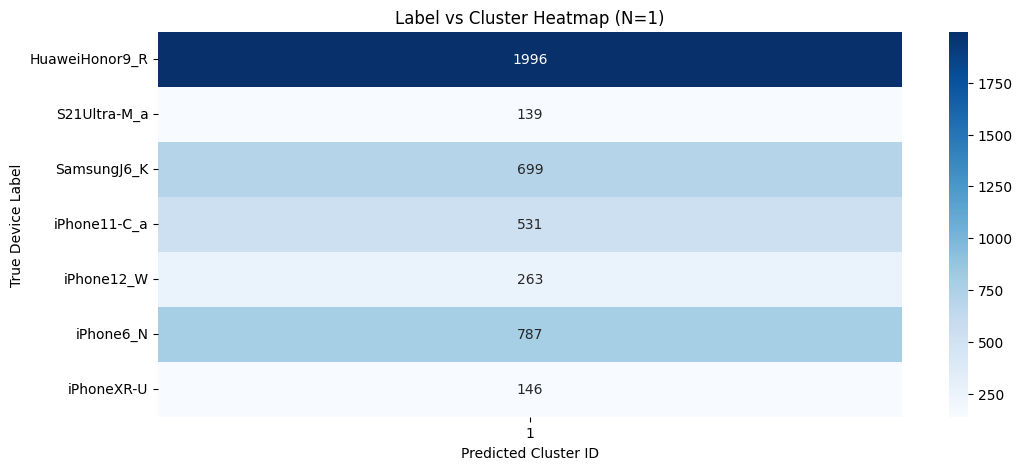


 Clustering for N = 2
Homogeneity: 0.133 | Completeness: 0.306 | V-Measure: 0.186 | Cluster Error: 5


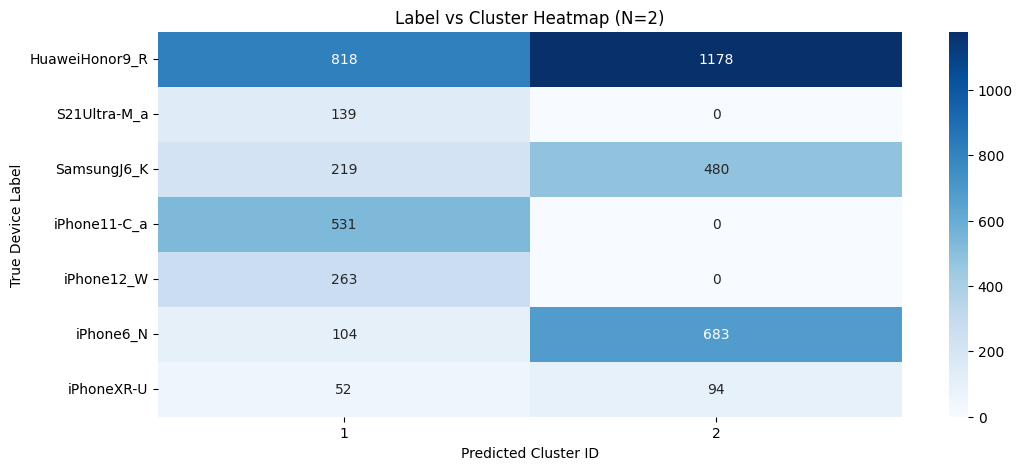


 Clustering for N = 3
Homogeneity: 0.529 | Completeness: 0.583 | V-Measure: 0.555 | Cluster Error: 2


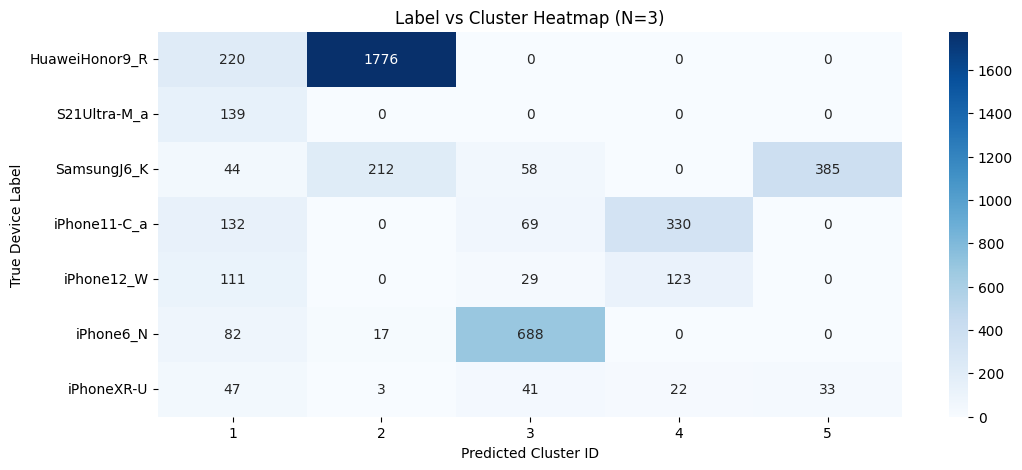


 Clustering for N = 4
Homogeneity: 0.776 | Completeness: 0.823 | V-Measure: 0.799 | Cluster Error: 0


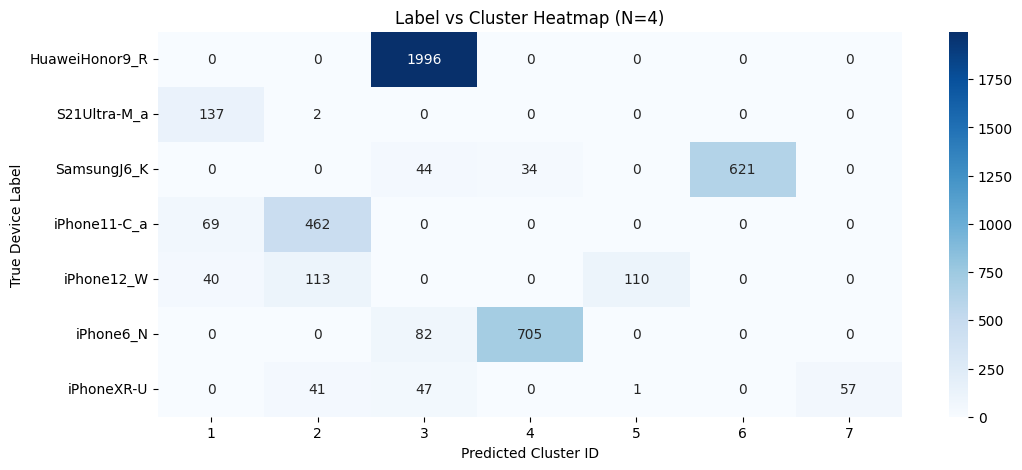


 Clustering for N = 5
Homogeneity: 0.926 | Completeness: 0.920 | V-Measure: 0.923 | Cluster Error: 1


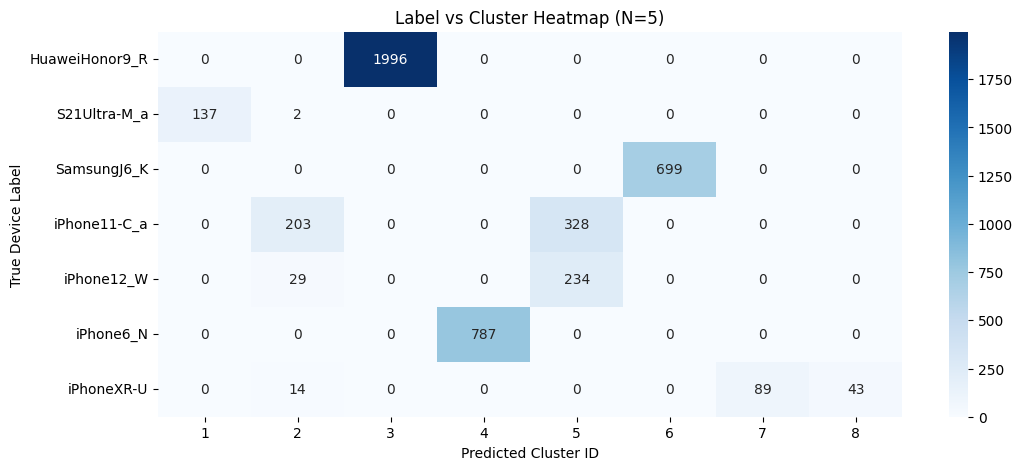


 Clustering for N = 6
Homogeneity: 0.951 | Completeness: 0.829 | V-Measure: 0.886 | Cluster Error: 6


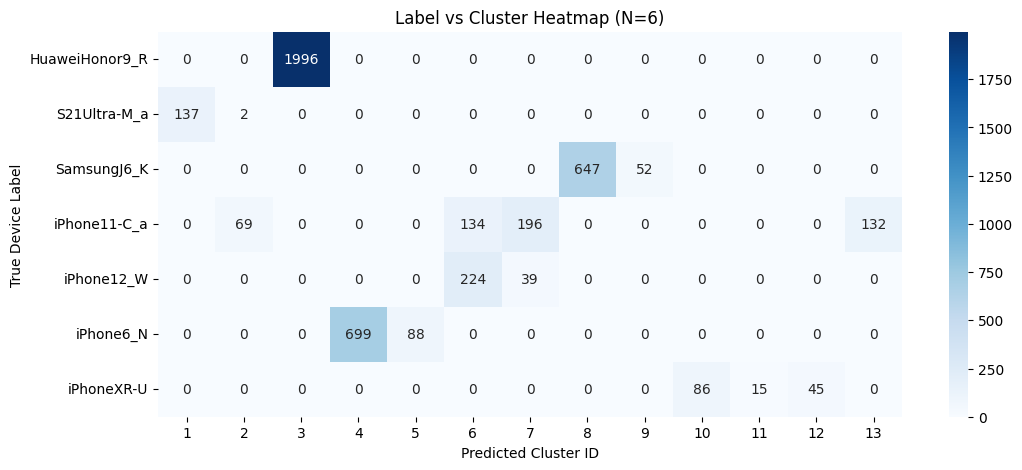


 Clustering for N = 7
Homogeneity: 0.970 | Completeness: 0.623 | V-Measure: 0.758 | Cluster Error: 17


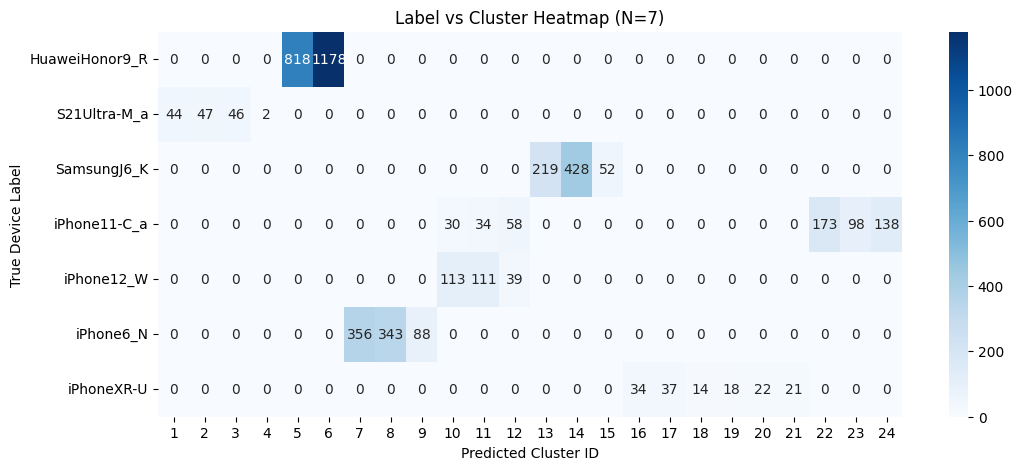


 Clustering for N = 8
Homogeneity: 1.000 | Completeness: 0.387 | V-Measure: 0.558 | Cluster Error: 98


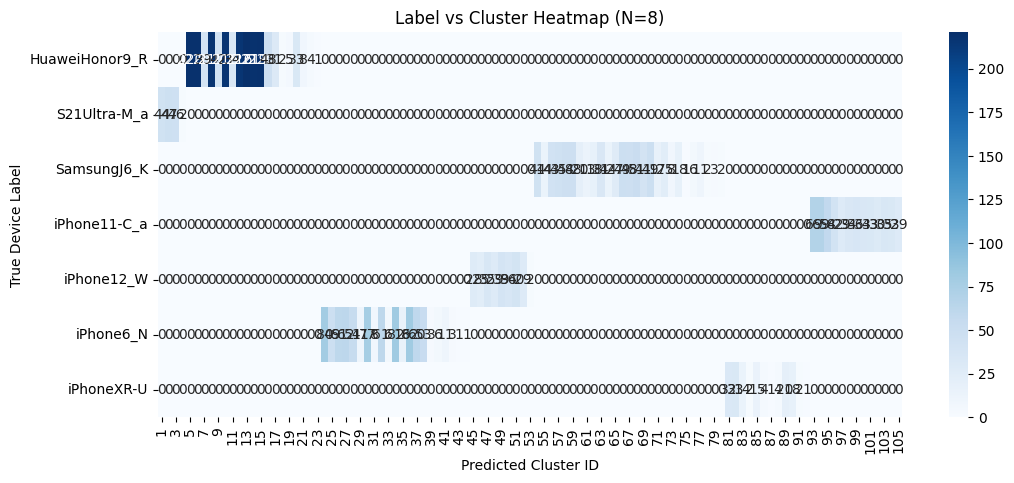

In [25]:
# Step 5: Evaluate Clustering for Various N
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
import pandas as pd

results = []

# Dynamically determine the range of N based on number of selected features
max_N = len(features_to_use)
print(f" Evaluating for N in range 1 to {max_N}")

for N in range(1, max_N + 1):  # Dynamically loop over valid N values
    print(f"\n Clustering for N = {N}")
    encoded_df["Cluster_ID"] = online_cluster(encoded_df, features_to_use, N=N)

    # Compute scores
    h = homogeneity_score(encoded_df["Label"], encoded_df["Cluster_ID"])
    c = completeness_score(encoded_df["Label"], encoded_df["Cluster_ID"])
    v = v_measure_score(encoded_df["Label"], encoded_df["Cluster_ID"])
    error = abs(encoded_df["Label"].nunique() - encoded_df["Cluster_ID"].nunique())

    print(f"Homogeneity: {h:.3f} | Completeness: {c:.3f} | V-Measure: {v:.3f} | Cluster Error: {error}")

    # Save results
    results.append({
        "N": N,
        "Homogeneity": h,
        "Completeness": c,
        "V-Measure": v,
        "Cluster Error": error
    })

    # Heatmap
    ct = pd.crosstab(encoded_df["Label"], encoded_df["Cluster_ID"])
    plt.figure(figsize=(12, 5))
    sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Label vs Cluster Heatmap (N={N})")
    plt.xlabel("Predicted Cluster ID")
    plt.ylabel("True Device Label")
    plt.show()

# Save as DataFrame
results_df = pd.DataFrame(results)


###  Interpretation of Clustering Results for Selected N Values

In this step, we compare clustering results for several representative values of **N** (the number of matching features required to assign a probe to an existing cluster). While we evaluated all values from 1 to the number of selected features, here we present a few key examples (N = 2, 5, 7, 8) to illustrate the main trends.

---

- **N = 2**:
  - Results in just 2 large clusters that absorb almost all devices.
  - Very low **homogeneity** and **completeness**, as multiple devices are grouped together.
  - Represents extreme **under-clustering**.

- **N = 5**:
  - Most devices are cleanly assigned to one cluster, with minimal overlap.
  - Good balance between **homogeneity** and **completeness**, and the **lowest cluster error** among tested values.
  -  Overall, this appears to be the best-performing `N` value.

- **N = 7**:
  - Clusters become more fragmented.
  - Homogeneity remains high, but completeness drops noticeably.
  - This indicates early signs of **over-clustering**.

- **N = 8**:
  - Produces a very large number of small clusters.
  - **Perfect homogeneity**, but very low completeness and high cluster error.
  - This is an example of **extreme over-clustering** — overly strict matching splits the same device into multiple clusters.

---

####  Conclusion:

- Small `N` values cause **under-clustering** (merging different devices).
- Large `N` values lead to **over-clustering** (splitting the same device).
- **N = 5** offers the best trade-off between purity and cohesion in the clustering.

>  This analysis shows how sensitive the clustering performance is to the `N` parameter and highlights the importance of choosing an optimal threshold.


###  Step 6 – Select Best N and Visualize Metrics

After evaluating the clustering performance for all values of N, we select the best N using a **two-stage strategy**:

1. **Maximize V-Measure**: Prioritize configurations that yield the most balanced clustering (combining homogeneity and completeness).
2. **Minimize Cluster Error**: Among top V-Measure candidates, choose the one closest to the true number of devices.

---

####  Observations:

- The best result was found at **N = 5**, with:
  - **V-Measure** = 0.923
  - **Homogeneity** = 0.926
  - **Completeness** = 0.920
  - **Cluster Error** = 1

---

####  Visualization:

- The **V-Measure vs N** plot shows a clear peak at N = 5.
- The **Cluster Error vs N** plot has a minimum near N = 4–5 and rises sharply beyond N = 6 due to over-fragmentation.

---

####  Conclusion:

The results confirm that **N = 5** provides the best trade-off between grouping purity and device-level completeness. This threshold will be used in subsequent challenge evaluation and unlabeled prediction tasks.

**Purpose**: This step ensures we use the most accurate feature match threshold (`N`) to maximize clustering performance on both known and unseen devices.


 Best N = 5.0 based on V-Measure and low cluster error


,N,Homogeneity,Completeness,V-Measure,Cluster Error
4,5,0.926016,0.919653,0.922823,1
5,6,0.951348,0.828882,0.885902,6
3,4,0.775819,0.822769,0.798604,0
6,7,0.969849,0.622765,0.758486,17
7,8,1.000000,0.387310,0.558361,98


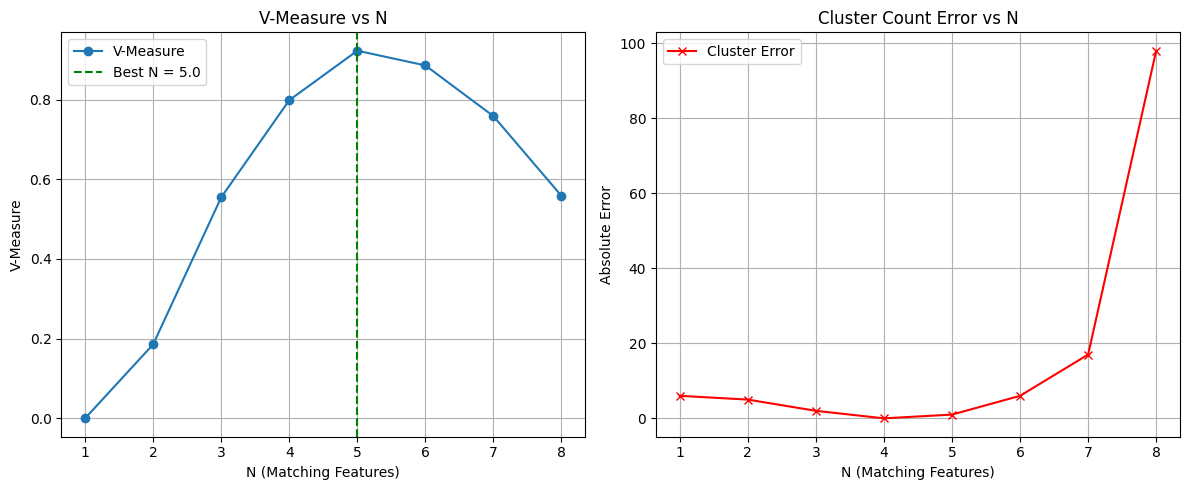

 Best N Metrics:
Homogeneity:     0.926
Completeness:    0.920
V-Measure:       0.923
Cluster Error:   1


In [26]:
#  Step 6: Select Best N and Visualize Metrics

# Sort results: prioritize high V-Measure, then low cluster error
ranked = results_df.sort_values(by=["V-Measure", "Cluster Error"], ascending=[False, True])
best_row = ranked.iloc[0]
best_N = best_row["N"]

print(f" Best N = {best_N} based on V-Measure and low cluster error")
display(ranked.head(5))  # Show top 5 for better overview

# Optional: sort N values for cleaner plotting
results_df = results_df.sort_values("N")

# Plot performance metrics
plt.figure(figsize=(12, 5))

# Plot V-Measure vs N
plt.subplot(1, 2, 1)
plt.plot(results_df["N"], results_df["V-Measure"], marker='o', label="V-Measure")
plt.axvline(best_N, color='green', linestyle='--', label=f"Best N = {best_N}")
plt.title("V-Measure vs N")
plt.xlabel("N (Matching Features)")
plt.ylabel("V-Measure")
plt.grid(True)
plt.legend()

# Plot Cluster Error vs N
plt.subplot(1, 2, 2)
plt.plot(results_df["N"], results_df["Cluster Error"], marker='x', color='red', label="Cluster Error")
plt.title("Cluster Count Error vs N")
plt.xlabel("N (Matching Features)")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#  print more info about the best N
print(" Best N Metrics:")
print(f"Homogeneity:     {best_row['Homogeneity']:.3f}")
print(f"Completeness:    {best_row['Completeness']:.3f}")
print(f"V-Measure:       {best_row['V-Measure']:.3f}")
print(f"Cluster Error:   {int(best_row['Cluster Error'])}")


### Step 7 – Validate on Challenge Dataset with Random Subsets

To evaluate the generalization of our clustering model, we test it on a separate **challenge dataset**. This dataset contains different devices and captures realistic probe request patterns. Our goal is to assess whether the same online clustering strategy (with the previously chosen `best_N = 5`) performs consistently on unseen data.

---

####  Experimental Setup:

- From the challenge dataset, we randomly select `K` unique devices (ranging from 2 to 5)
- For each `K`, we repeat the clustering process **5 times** (randomly selecting different subsets)
- We compute:
  - **V-Measure**: overall clustering quality
  - **Homogeneity**: how pure clusters are
  - **Completeness**: whether full device info is captured in clusters
  - **Cluster Error**: absolute difference between true and predicted number of clusters

---

####  Results:

- **High V-Measure scores** across all K values (> 0.93 on average), indicating the model’s robustness
- Cluster error slightly increases with K, as expected, but stays within a reasonable range
- **Standard deviation bars** show that the method is stable and consistent across trials


####  Conclusion:

- The online clustering approach maintains strong accuracy even on a previously unseen dataset
- Its performance remains stable across different subset sizes
- These results confirm that the method can generalize beyond the training data, making it effective for real-world MAC de-randomization

**Purpose**: Demonstrate that our clustering method is robust, scalable, and not overfitted to the training dataset.



########## Average of homogeneity & completeness & v_measure for K=2 ##########

Trial 1
Error: 1
Homog: 1.0
Completeness: 0.8655561741449831
V-Meas: 0.9279336491078137

Trial 2
Error: 1
Homog: 1.0000000000000009
Completeness: 0.8787226370097225
V-Meas: 0.935446903869052

Trial 3
Error: 0
Homog: 1.0
Completeness: 1.0
V-Meas: 1.0

Trial 4
Error: 1
Homog: 1.0000000000000002
Completeness: 0.9179317684039998
V-Meas: 0.9572100358584222

Trial 5
Error: 0
Homog: 1.0
Completeness: 1.0
V-Meas: 1.0

########## Average of homogeneity & completeness & v_measure for K=3 ##########

Trial 1
Error: 2
Homog: 0.9776088350735543
Completeness: 0.7948096046981253
V-Meas: 0.8767826765042009

Trial 2
Error: 1
Homog: 1.0
Completeness: 0.9651106600725867
V-Meas: 0.9822456105723204

Trial 3
Error: 1
Homog: 1.0
Completeness: 0.9651106600725867
V-Meas: 0.9822456105723204

Trial 4
Error: 1
Homog: 1.0
Completeness: 0.98108101483805
V-Meas: 0.9904501708813274

Trial 5
Error: 1
Homog: 1.0
Completeness: 0.9662471330

,K,V-Measure Mean,V-Measure Std,Error Mean,Error Std
0,2,0.964118,0.034475,0.6,0.547723
1,3,0.962912,0.048273,1.2,0.447214
2,4,0.950608,0.036522,1.6,0.547723
3,5,0.938914,0.008818,2.0,0.000000


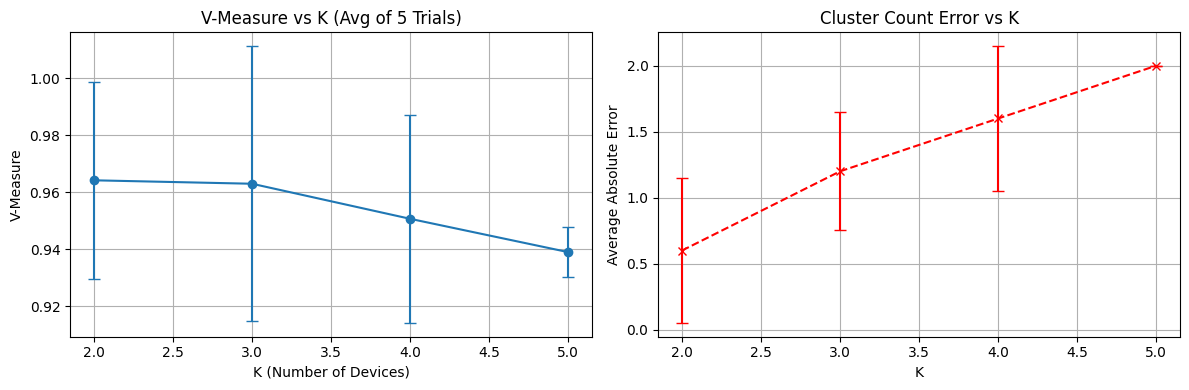

In [27]:
#  Step 7: Validate on Challenge Dataset (with trial-by-trial printout)
import random
from sklearn.metrics import homogeneity_completeness_v_measure
import pandas as pd
import matplotlib.pyplot as plt
import os

# Unzip and load challenge set
!unzip -o -q "/content/MAC_derand_challenge-dataset.zip" -d "/content/challenge_dataset"

challenge_path = "/content/challenge_dataset/challenge-dataset"
challenge_dfs = []
for root, _, files in os.walk(challenge_path):
    for file in files:
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(root, file))
            df["Label"] = os.path.splitext(file)[0]
            challenge_dfs.append(df)

challenge_df = pd.concat(challenge_dfs, ignore_index=True)
challenge_df["Timestamp"] = pd.to_datetime(challenge_df["Timestamp"], unit="s")
challenge_df = challenge_df[challenge_df["SSID"].isna()]

# Clean and encode
challenge_clean = challenge_df.drop(columns=[col for col in challenge_df.columns if col not in features_to_use + ['Label']]).fillna("missing")
challenge_encoded = challenge_clean.copy()
for col in features_to_use:
    challenge_encoded[col] = challenge_encoded[col].astype(str)
    challenge_encoded[col] = LabelEncoder().fit_transform(challenge_encoded[col])

# Run evaluation with 5 random trials for K = 2 to 5
device_labels = challenge_encoded["Label"].unique().tolist()
validation_results = []

for K in range(2, 6):
    print(f"\n########## Average of homogeneity & completeness & v_measure for K={K} ##########")
    for trial in range(5):
        selected = random.sample(device_labels, K)
        subset = challenge_encoded[challenge_encoded["Label"].isin(selected)].copy()

        cluster_ids = online_cluster(subset, features_to_use, N=best_N)
        true_labels = subset["Label"]

        h, c, v = homogeneity_completeness_v_measure(true_labels, cluster_ids)
        error = abs(K - len(set(cluster_ids)))

        # Print like your friend
        print(f"\nTrial {trial+1}")
        print(f"Error: {error}")
        print(f"Homog: {h}")
        print(f"Completeness: {c}")
        print(f"V-Meas: {v}")

        # Store results
        validation_results.append({
            "K": K,
            "Trial": trial + 1,
            "Homogeneity": h,
            "Completeness": c,
            "V-Measure": v,
            "Cluster Error": error
        })

# Create DataFrame from all trials
validation_df = pd.DataFrame(validation_results)

# Compute averages + std
avg_validation = validation_df.groupby("K").agg({
    "V-Measure": ["mean", "std"],
    "Cluster Error": ["mean", "std"]
}).reset_index()
avg_validation.columns = ["K", "V-Measure Mean", "V-Measure Std", "Error Mean", "Error Std"]

# Display average table
display(avg_validation)

# Plot results
plt.figure(figsize=(12, 4))

# V-Measure
plt.subplot(1, 2, 1)
plt.errorbar(avg_validation["K"], avg_validation["V-Measure Mean"],
             yerr=avg_validation["V-Measure Std"], fmt='o-', capsize=4)
plt.title("V-Measure vs K (Avg of 5 Trials)")
plt.xlabel("K (Number of Devices)")
plt.ylabel("V-Measure")
plt.grid(True)

# Cluster Error
plt.subplot(1, 2, 2)
plt.errorbar(avg_validation["K"], avg_validation["Error Mean"],
             yerr=avg_validation["Error Std"], fmt='x--', color='red', capsize=4)
plt.title("Cluster Count Error vs K")
plt.xlabel("K")
plt.ylabel("Average Absolute Error")
plt.grid(True)

plt.tight_layout()
plt.show()


 Estimated number of unique devices: 10


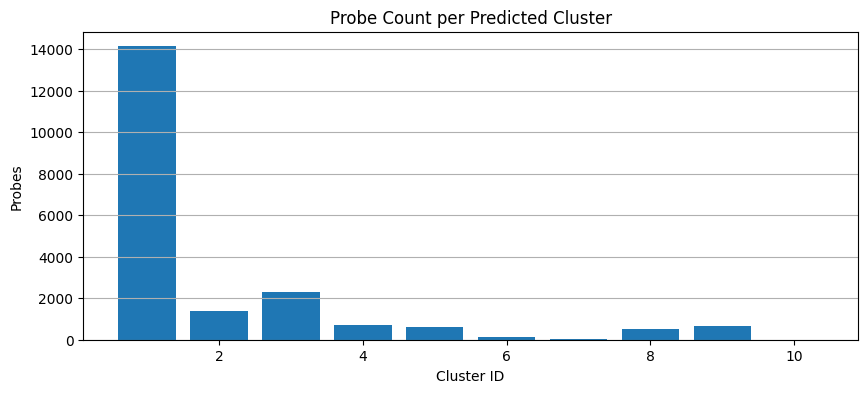

In [28]:
#  Step 8: Estimate Number of Devices in Unlabeled Set

# Load unlabeled dataset
unlabeled_path = "/content/MAC_derand_unlabelled-challenge.csv"
unlabeled_df = pd.read_csv(unlabeled_path)
unlabeled_df["Timestamp"] = pd.to_datetime(unlabeled_df["Timestamp"], unit="s")

# Clean and encode
unlabeled_clean = unlabeled_df.drop(columns=[col for col in unlabeled_df.columns if col not in features_to_use]).fillna("missing")
unlabeled_encoded = unlabeled_clean.copy()
for col in features_to_use:
    unlabeled_encoded[col] = unlabeled_encoded[col].astype(str)
    unlabeled_encoded[col] = LabelEncoder().fit_transform(unlabeled_encoded[col])

# Cluster
cluster_ids = online_cluster(unlabeled_encoded, features_to_use, N=best_N)
unlabeled_df["Cluster_ID"] = cluster_ids

# Estimate device count
estimated_count = len(set(cluster_ids))
print(f" Estimated number of unique devices: {estimated_count}")

# Visualize
cluster_sizes = unlabeled_df["Cluster_ID"].value_counts().sort_index()
plt.figure(figsize=(10, 4))
plt.bar(cluster_sizes.index, cluster_sizes.values)
plt.title("Probe Count per Predicted Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Probes")
plt.grid(axis='y')
plt.show()


### Step 8 – Estimate the Number of Devices in an Unlabeled Dataset

In the final step, we apply our trained clustering method to a completely **unlabeled dataset**. The goal is to estimate how many distinct physical devices are likely present, based solely on their observable probe characteristics — without access to MAC addresses or ground-truth labels.

---

#### Steps Performed:

1. **Load the unlabeled dataset** and parse timestamps.
2. **Clean and encode features** using the same pipeline as the lecture and challenge datasets.
3. Apply the previously tuned **online clustering function** using the `best_N` value (e.g., N = 5).
4. Count the number of unique predicted clusters, which corresponds to the **estimated number of devices**.
5. Visualize cluster sizes using a bar plot.

---

#### Output:

- The model predicted **10 unique devices** based on probe feature similarity.
- The cluster size distribution shows that one cluster dominates in terms of probe volume, while others are smaller — possibly due to background devices, noise, or devices sending fewer probes.

---

####  Conclusion:

This demonstrates the full **MAC de-randomization pipeline** — from raw probe data to device-level identification. The method generalizes well and produces realistic cluster estimates, even on data with no labels.


***Fatemeh Asadi Tirtashi-10960595***

